In [ ]:
# our own script
from DreadScraper import DreadSession

# visual
from tqdm.auto import tqdm

# data handeling
import json
import csv
import pandas as pd
import os

# link scraping
import re
from requests_tor import RequestsTor
from bs4 import BeautifulSoup

# wordclouds and text analysis
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import math


# network analysis
import networkx as nx
import netwulf as nw
import networkit as nk
from networkx.readwrite import json_graph
from community.community_louvain import best_partition

# Motivation

The dataset used in this project is sourced from <span style="color: purple; font-weight: bold;">Dread</span>, specifically the <span style="color: purple; font-weight: bold;">/d/DarkNetMarkets</span> forum.

Our data consists of allmost all conversations (posts and comments) on this subforum. This dataset provides a rich foundation to analyse and understand the overall dynamics and events on the dark marketplaces and their clients.

The dark web remains fragmented and poorly understood by researchers. Gaining insight of these marketplace discussions helps reveal how underground economies operate, how communities adapt to takedowns, and what products dominate these hidden markets.

Our goal is to provide an understanding for the average non-technical person to gain a better understanding of what the dark web marketplaces are, what goes on there, how they function, and how the users interact and behave.

---

# Basic Stats

The dataset consists of two files:

### posts_data_unique.csv
<div style="border-left: 4px solid #2ca02c; padding-left: 12px; line-height: 1.6em;">
<pre style="font-size: 14px; line-height: 1.6em;">
<span style="color: #2ca02c; font-weight: bold;">30,793 users</span>        — The number of users who have written something (out of 155,000+ users)
<span style="color: #2ca02c; font-weight: bold;">64.3 MB</span>             — Total file size
<span style="color: #2ca02c; font-weight: bold;">6 variables</span>         — Describing user activity and content
<span style="color: #2ca02c; font-weight: bold;">16,116 posts</span>        — The total number of posts
<span style="color: #2ca02c; font-weight: bold;">181,400 comments</span>    — Total number of comments on every post and comment
<span style="color: #2ca02c; font-weight: bold;">197,516 entries</span>     — The total number rows in the dataset
<span style="color: #2ca02c; font-weight: bold;">19.4.2025</span>           — Start date for data collection
<span style="color: #2ca02c; font-weight: bold;">21.4.2025</span>           — End date for data collection
</pre>
</div>

Each row in the dataset corresponds to either a post or a comment, and contains the following variables:

<div style="border-left: 4px solid #9467bd; padding-left: 12px; line-height: 1.6em;">
<pre style="font-size: 14px; line-height: 1.6em;">
<span style="color: #9467bd; font-weight: bold;">type</span>                — Entry type; <span style="color: #ff7f0e;">post</span> or <span style="color: #ff7f0e;">comment</span>
<span style="color: #9467bd; font-weight: bold;">id</span>                  — Unique identifier
<span style="color: #9467bd; font-weight: bold;">parent_id</span>           — Parent reference; <span style="color: #ff7f0e;">None</span> if it is a post, otherwise the id of the post or comment it replies to
<span style="color: #9467bd; font-weight: bold;">title</span>               — Post title (blank for comments)
<span style="color: #9467bd; font-weight: bold;">author</span>              — Author username, which is also the unique identifier of the user
<span style="color: #9467bd; font-weight: bold;">content</span>             — Post or comment text
</pre>
</div>


Initially 1474 links were found in the 197,516 texts. After removing v1 & v2 links and duplicates 212 addresses remained, of whitch only 59 were responsive. Version 1 and 2 links are recognized by their hash lenght. See the text below for an explanation on onion addresses.

We were able to scrape these sites and gain some information on their contents. out of the 59 adresses, there were 30 unique pages. most of the pages were login sites or pages that has been taken down by FBI or BKA. this makes text analysis of the pages meaningless.

More aliases and links to marketplaces have been found manually by reading thru the contents of the datasets. Dread however has strict rules about link sharing. Posts that include links have to be approved by moderators, so the links are restricted to marketplaces that are well known in the forum.


### links_to_sites.csv

<div style="border-left: 4px solid #2ca02c; padding-left: 12px; line-height: 1.6em;">
<pre style="font-size: 14px; line-height: 1.6em;">
<span style="color: #2ca02c; font-weight: bold;">59 addresses</span>        — Responsive v3 onion addresses when scraping
<span style="color: #2ca02c; font-weight: bold;">2.5.2025</span>            — Date of data collection by scraping
<span style="color: #2ca02c; font-weight: bold;">93 marketplaces</span>     — Total unique market places found from reading and scraping
<span style="color: #2ca02c; font-weight: bold;">8.0 KB</span>              — Total file size
<span style="color: #2ca02c; font-weight: bold;">3 variables</span>         — Describing the address and its content
</pre>
</div>

The dataset contains the following variables:

<div style="border-left: 4px solid #9467bd; padding-left: 12px; line-height: 1.6em;">
<pre style="font-size: 14px; line-height: 1.6em;">
<span style="color: #9467bd; font-weight: bold;">name</span>                — The manually chosen name for the marketplace
<span style="color: #9467bd; font-weight: bold;">alias</span>               — Page name/alias of the onion address, either automatic from HTML <span style="color: green;"><</span><span style="color: blue;">title</span><span style="color: green;">></span> or manually added
<span style="color: #9467bd; font-weight: bold;">addresses</span>           — Mostly v3 links found and verified with scraping, but also a few manual links taken from the context of contents
</pre>
</div>

---

<span style="color: #1f77b4; font-weight: bold;">Onion addresses</span> are unique identifiers used to access hidden services on the Tor network. Unlike traditional domains that rely on DNS and IP addresses, onion addresses are resolved through Tor’s <span style="color: #1f77b4; font-weight: bold;">distributed hash table (DHT)</span>, allowing users to connect to the endpoints of servers. This endpoint is similar to the endpoint of your onion circuit. This is what keeps you both anonymous. If you dont know about onion routing, imagine connecting to 3 VPNs in a row. the last "VPN" is the endpoint.

Each address is a hash derived from a cryptographic public key, serving as both the server’s <span style="color: #1f77b4; font-weight: bold;">identity</span> and its <span style="color: #1f77b4; font-weight: bold;">encryption mechanism</span>. This eliminates the need for HTTPS or certificate authorities — the Tor protocol handles end-to-end encryption internally.

Earlier versions used <span style="color: #1f77b4; font-weight: bold;">16-character</span> addresses (<span style="color: #1f77b4; font-weight: bold;">v2</span>), but since <span style="color: #1f77b4; font-weight: bold;">October 2021</span>, only <span style="color: #1f77b4; font-weight: bold;">v3</span> addresses are valid, which are <span style="color: #1f77b4; font-weight: bold;">56 character</span> long and cryptographically stronger.

<span style="font-weight: bold;">Regex pattern for v3 onion addresses:</span> <span style="color: #666666;">/</span><span style="color: #2ca02c;">(</span><span style="color: #1f77b4;">http</span><span style="color: purple;">://</span><span style="color: #ff7f0e;">[a-z2-7]{56}</span><span style="color: yellow;">\.onion</span><span style="color: #2ca02c;">)</span><span style="color: #666666;">/</span>

<span style="font-weight: bold;">The Dread forum address: </span> <span style="color: #1f77b4;">http</span><span style="color: purple;">://</span><span style="color: #ff7f0e;">dreadytofatroptsdj6io7l3xptbet6onoyno2yv7jicoxknyazubrad</span><span style="color: yellow;">\.onion</span>

---


There were quite a bit of hurdles to overcome, when scraping Dread. Forums and pages with illegal content can't enforce legal TOS, so they have more agressive anti-scraping / anti-botting than clear web sites. When the scraper was detected a significant throtteling was applied to the requests, and we had to wait for several hours befor we could scrape at full speed again. This is one of the primary reasons why the data was collected over three days. onion routing is in general also alot slower than clear web routing. On average, scraping without being throttled performed at 2 requests per second. We have made a tool - <span style="color: orange;">DreadScraper.DreadSession</span> - to use different kinds of obfuscation techniques.

If you are interested in the full code for the webscraper, please check out the <span style="color: #1f77b4; font-weight: bold;">Gitlab repository</span> for the project: <span style="color: #1f77b4;">https://gitlab.gbar.dtu.dk/s224234/socsciproject</span>

### <span style="color: Red">Disclamer:</span> If you want to use the webscraper, you need to do it on from own system and not the online jupyter environment. You also need to concider the risks associated with .onion scraping

In [2]:
'''
We need a CAPTCHA token and a session token to scrape the Dread forums.
This is one of dreads many anti-bot measures.
you can get the cookies by going to the page manually and copying them from your browser.

The cookies below are not going to work for you, they expire after a few hours.
'''
cookies = {
            "dcap": "IHVQMdlawnCAxp2YxNKU8mdkAH5z2z+VRYIDfOby13MYgfbGvdKh/Jv39VglgbiVNa5yXv32eFIJ0N4tFsByY6KNh5RAU0kR/3PWbm/ca0V0aSqGcrtJb8A1z0Y+jtZW53xs2K2kfTh/bUokKp2WNK/FyZxH0UA=",
            "dread": "s6ugremq1j0cdkru54n7tfbp4m"
        }

# Initialize the session with the cookies
session = DreadSession(cookies=cookies)

# you can check your access to onion service and dread forums
# by running the following command
tor,dread = session.status(verbose=True)

if not tor:
    print("you dont have a working tor connection, or you dont have internet access")
if not dread:
    print("your cookies are probably wrong")


Checking Tor configuration...[OK] Tor is configured correctly.

Checking Dread access...[OK] Connected to Dread successfully.


The data collection was done using the <span style="color: #1f77b4; font-weight: bold;">BeautifulSoup</span> library for parsing html.

The structure of the forum is similar to that of Reddit, with posts and comments. The posts are displayed in a list format. The pagination process is quite simple and can be done by simply adding page numbers and sorting method to the url.

> <span style="color: #888888;">http://</span><span style="color: #888888;">dreadytofatroptsdj6io7l3xptbet6onoyno2yv7jicoxknyazubrad.onion</span><span style="color: purple;">/d/darknetmarkets/</span><span style="color: red;">?</span><span style="color:rgb(81, 182, 255);">sort</span><span style="color: red;">=</span><span style="color: #2ca02c;">new</span><span style="color: red;">&</span><span style="color:rgb(81, 182, 255);">p</span><span style="color: red;">=</span><span style="color: #2ca02c;">1</span>


and the html structure allows us to easily extract the post links

```html
<div class="postBoard">
    <div class="item">
        <div class="postTop">
            <a class="title" href="/post/ID_HERE">Title of post</a>
            ...
        </div>
        <div class="postMain"> ... </div>
    </div>
    <div class="item"> ... </div>
    <div class="item"> ... </div>
    <div class="item"> ... </div>
    <div class="item"> ... </div>
</div>
```

In [4]:
# lets just get the 20 ids on the first page of DarkNetMarkets
subforum = 'darknetmarkets'
post_ids = session.get_post_ids(subforum, start_from=1, sort="new", pagination=False, Verbrose=True) # getting ids from the first page

print(post_ids)

Posts found: 20
['1ac65a9e4188f69f8b17', '139ab47211d264cfc22b', 'f7bb70dc5d2564b7d4e7', 'fa7bfa8dee009980518b', 'c76dc8353ef96190856c', '1a3293beec314767696e', '6624334a53ee3faf42c3', 'b96d7f4085848151166b', '97434834044423057ab2', 'da9ca872ad38c77c1ff4', '38ae1fc2980419a18094', '806838f1e19939ffcaaa', '88b5e3bfbf95f2d2108a', '5def8253e4e88845a0db', 'e6a96d14edc2728999fa', '5dd1df10f43cc246ece8', 'c5d49ea61ab450006bf6', '5cedae0638227dec20f9', 'ba8587094e96c2874ccf', 'bb60ac95f16bac956c88']


When we click on a post, we are taken to a new page with the post content and the comments. The url for the post is simply the id of the post, which is also the id of the post in the dataset. The url looks like this:

> <span style="color: #888888;">http://</span><span style="color: #888888;">dreadytofatroptsdj6io7l3xptbet6onoyno2yv7jicoxknyazubrad.onion</span><span style="color: purple;">/post/ID_HERE</span>

The structure of the html on the posts are convenient to handle for our purpose. The structure we are interested in, can be summed down to the following:

```html
<div class="postBoard viewPost">
    <div class="item">
        <div class="postTop">
            <a class="title" href="/post/ID_HERE">Title of post</a>
            <div class="author"> by <a href="/u/username">/u/username</a>...</div>
            ...
        </div>
        <div class="postMain">
            <div class="postContent"> text content </div>
            ...
        </div>
    </div>
</div>

...

<div class="postComments">
    <div class="comment">

        <div class="commentContent">
            <div class="top"><a href="/u/username" class="username">/u/username</a>...</div>
            <div class="commentBody"> text content </div>
            ...
        </div>
        <div class="comment">
            <div class="comment"> ... </div>
            <div class="comment"> ... </div>
            ...
        </div>
        ...
    </div>
    <div class="comment"> ... </div>
    <div class="comment"> ... </div>
    <div class="comment"> ... </div>
</div>
```

In [5]:
output_csv_path = "Data/explainer_posts.csv"


# this is simply for the sake of the explainer to not have duplicates or old data in the file
file_exists = os.path.exists(output_csv_path)
if file_exists:
    os.remove(output_csv_path)  # Remove the existing file to start fresh
    file_exists = False # Reset the flag after deletion


with open(output_csv_path, "a", encoding="utf-8", newline="") as csvfile:
    writer = None

    for post_id in tqdm(post_ids, desc="Fetching post content", unit="post"):
        _, data = session.get_post_content(post_id)

        if not data:
            continue  # skip empty results

        if writer is None:
            # Initialize CSV writer with fieldnames from first dict
            writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
            if not file_exists:
                writer.writeheader()

        # Write each comment row
        for row in data:
            writer.writerow(row)

Fetching post content:   0%|          | 0/20 [00:00<?, ?post/s]

Fetching post content: 100%|██████████| 20/20 [00:27<00:00,  1.36s/post]


In [6]:
data = pd.read_csv('Data/explainer_posts.csv')

print(f'Total number of posts and comments: {len(data)}')
print(f'Total number of unique users: {len(data["author"].unique())}')

posts = data[data['type'] == 'post']
print(f'Number of posts: {len(posts)}')
print(f'Number of unique posts: {len(posts["id"].unique())}')


comments = data[data['type'] == 'comment']
print(f'Number of comments: {len(comments)}')
print(f'Number of unique comments: {len(comments["id"].unique())}')

data.head()

Total number of posts and comments: 183
Total number of unique users: 101
Number of posts: 20
Number of unique posts: 20
Number of comments: 163
Number of unique comments: 163


,type,id,parent_id,title,author,content
0,post,1ac65a9e4188f69f8b17,NaN,how risky is getting packages sent to the USA ...,pandadaddy,Curious because most speed vendors are eu base...
1,comment,c-042759dbec1a35d9a0,1ac65a9e4188f69f8b17,NaN,Phobos36,Edit: nevermind i just misread the post. Avoid...
2,comment,c-1fec40945d6cacde9c,1ac65a9e4188f69f8b17,NaN,witch,Use the handful of speed vendors in the US. If...
3,comment,c-2e8973e894e623b695,1ac65a9e4188f69f8b17,NaN,miner21,Ask the vendor what their success rate is? I i...
4,comment,c-5f959ef17f7345daca,1ac65a9e4188f69f8b17,NaN,natethedrake,"I have done it several times successfully, but..."


When we scraped the entire subforum it was, as previously mentiond, done over the span of 3 days (with a total active scraping time of about 3-5 hours). to avoid missing anything, there was a small overlap from the end of the last scraping session. We can remove duplicates by id.

There a obviously no duplicates in these 20 posts, but the code below can be used to remove duplicates.

In [7]:
unique_data = data.drop_duplicates(subset=['id'], keep='first')
print(f'Number of unique posts and comments: {len(unique_data)}')

unique_data.to_csv('Data/explainer_posts_unique.csv', index=False)

unique_data.head()

Number of unique posts and comments: 183


,type,id,parent_id,title,author,content
0,post,1ac65a9e4188f69f8b17,NaN,how risky is getting packages sent to the USA ...,pandadaddy,Curious because most speed vendors are eu base...
1,comment,c-042759dbec1a35d9a0,1ac65a9e4188f69f8b17,NaN,Phobos36,Edit: nevermind i just misread the post. Avoid...
2,comment,c-1fec40945d6cacde9c,1ac65a9e4188f69f8b17,NaN,witch,Use the handful of speed vendors in the US. If...
3,comment,c-2e8973e894e623b695,1ac65a9e4188f69f8b17,NaN,miner21,Ask the vendor what their success rate is? I i...
4,comment,c-5f959ef17f7345daca,1ac65a9e4188f69f8b17,NaN,natethedrake,"I have done it several times successfully, but..."


This is how the entire dataset <span style="color: blue">posts_data_unique.csv</span> was collected.

---

From now on we will be using the <span style="color: blue">posts_data_unique.csv</span> dataset.

For the discovery of functional addresses and their contents we used regex on the contents from the posts and comments.

In [39]:
data = pd.read_csv('Data/posts_data_unique.csv')

# remove posts/comments that are removed or pending or the author is AutoModerator
filtered_data = data.drop([index for index, row in data.iterrows() if row['content'] == '[removed by moderators]' or row['content'] == '[removed]' or row['content'] == '[pending moderation]' or row['author'] == 'AutoModerator' or row['author'] == '[deleted]'])
filtered_data['content'] = filtered_data['content'].str.lower()

filtered_data

,type,id,parent_id,title,author,content
2,comment,c-cd1a5396ac26364ea4,f4eab59ac6294633518b,NaN,MansGotPlans,/u/samwhiskey
3,post,0e6c390afaf39e258061,NaN,Summary of today,BigBossChefOfArchetyp,"hey,\r\n we are super sorry for the interrupti..."
4,comment,c-746048b62efa6d86be,c-b143bd489e97097758,NaN,cognac,ocbts. one comment by this shill.
5,comment,c-b143bd489e97097758,c-9578a687fa2916ae12,NaN,CatGecko,"same here, super annoying being in an endless ..."
6,comment,c-be1f4cb4cc8106d080,c-38fd9789c067729b27,NaN,PLABoi,i'm also experiencing the same issue.
...,...,...,...,...,...,...
197509,comment,c-ea7278ac33ee6846ad,a68b32d320636b592244,NaN,OZDrugs,marketannouncements is for all markets or just...
197512,comment,c-972db72489117be68c,a68b32d320636b592244,NaN,WeedManNG,i bought some flower off pinkpanthernl on sr w...
197513,comment,c-3d3d446d2895c81818,c-1ea3c262e25ad4ec99,NaN,ibeto,why is it not visible ?
197514,comment,c-1ea3c262e25ad4ec99,c-55f4b2a94ef118fecf,NaN,wombat2combat,"no, only hug the dread admin can see it."


In [9]:
# search for website links before tokenizing, onion links contain http:// in the beginning and .onion in the end
def find_onion_links(content):
    # skip if content is not a string
    if not isinstance(content, str):
        return []
    
    # links containing both http:// and .onion
    http_onion = re.compile(r'https?://[^\s]+\.onion(?:[/\w\-]*)')

    # links containing only .onion
    onion = re.compile(r'(?<!://)\b[\w\-]+\.onion(?:[/\w\-]*)')

    links = []

    #process in chunks
    chunk_size = 1000

    for i in range(0, len(content), chunk_size):
        chunk = content[i:i+chunk_size]
        links.extend(http_onion.findall(chunk))
        links.extend(onion.findall(chunk))
    
    # remove duplicates and clean up links
    unique_links = []
    seen = set()
    for link in links:
        # add http:// if not beginning with http://
        if link.startswith('http'):
            clean_link = link.split()[0].rstrip('.,;!?')
        else:
            clean_link = 'http://' + link.split()[0].rstrip('.,;!?')
        
        if clean_link not in seen:
            seen.add(clean_link)
            unique_links.append(clean_link)
        
    return unique_links

# Process data in smaller batches
batch_size = 1000
onion_links = []

for i in tqdm(range(0, len(filtered_data), batch_size)):
    batch = filtered_data.iloc[i:i+batch_size]
    for _, row in batch.iterrows():
        links = find_onion_links(row['content'])
        if links:
            onion_links.extend(links)

print(f"Found {len(onion_links)} onion links from contents.")

100%|██████████| 190/190 [00:23<00:00,  8.11it/s]

Found 1474 onion links from contents.


In [10]:
unique_v3 = []
for link in tqdm(onion_links):
    match = re.search(r'(http://[a-z2-7]{56}\.onion)', link)
    if match:
        unique_v3.append(match.group(1))

unique_v3 = list(set(unique_v3))
print("{} unique v3 links were found".format(len(unique_v3)))


session = RequestsTor(tor_ports=(9050,), 
                        tor_cport=9051,
                        password=None,
                        autochange_id=0)

alive_v3 = []
for link in tqdm(unique_v3):
    try:
        response = session.get(link, timeout=10)
        if response.status_code == 200:
            alive_v3.append(link)
    except:
        continue
print("{} of the links are responding".format(len(alive_v3)))

100%|██████████| 1474/1474 [00:00<00:00, 175347.56it/s]


212 unique v3 links were found


100%|██████████| 212/212 [20:33<00:00,  5.82s/it]

55 of the links are responding


right now (16.5.2025) we only found 55 compared to the 59 (2.5.2025) where the code was run multiple times with a higher timeout. You can run it again with a higher timeout. but this will increase the runtime greatly.

In [11]:
data = pd.DataFrame(columns=['address', 'alias', 'content'])

for link in tqdm(alive_v3):
    try:
        response = session.get(link, timeout=60)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            address = link
            alias = soup.find('title').text.strip().replace("\n", " ") if soup.find('title') else '### Insert Title Here ###''' # we will change the title manually if it contains more than just the name of the site
            content = soup.find('body').text.strip().replace("\n", " ") if soup.find('body') else '### Insert Content Here ###'
            data.loc[len(data)] = {'address': address, 'alias': alias, 'content': content}
    except Exception as e:
        print (f"Error fetching {link}: {e}")
        
data.head()
# data.to_csv('Data/links_data.csv', index=False) we dont want to change the dataset in the explainer notebook, in case something is changed from the original dataset

100%|██████████| 55/55 [04:02<00:00,  4.42s/it]


,address,alias,content
0,http://superxxx2daymhfxbxfzlg2zevkwqyvisngvphz...,SuperMarket to DrugHub Migration status,SuperMarket user base and orders have been mer...
1,http://cieprrpdgp7moka2ktlwy54ooymtgsre23enrf4...,Please Wait,-----BEGIN PGP SIGNED MESSAGE----- Hash: SHA51...
2,http://6emgxas4pvwhegctqemi3b64zhrr7xdryasgbkt...,About The Project | Infinity,projectall our servicesabout usexchangersign i...
3,http://auzbdiguv5qtp37xoma3n4xfch62duxtdiu4cfr...,Please Wait,-----BEGIN PGP SIGNED MESSAGE----- Hash: SHA51...
4,http://dumpliwoard5qsrrsroni7bdiishealhky4snig...,dump.li - image hosting & markdown pastebin,contact / abuse file expiry: 1...


In [12]:
# This original dataset was created 2.5.2025
links_data = pd.read_csv('Data/links_data.csv')
links_data.head()

,address,alias,content
0,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,NEMESIS MARKET HAS BEEN SEIZED,THIS PLATFORM HAS BEEN SEIZED by the Federal C...
1,http://tcecdnp2fhyxlcrjoyc2eimdjosr65hweut6y7r...,TCEC-NPN,FAQ Verification PGP-public key Canary Seized ...
2,http://benzosbbvk7gu6taxbjpcpsi3u3dgg3wb3ewwr4...,BestBenzos,NaN
3,http://p7nplvfgb4yxovywiwtq74tjjirel7wx6vigthh...,Infinity,projectall our servicesabout usexchangersign i...
4,http://dhme3vnfeleniirt5nxuhpmjsfq5srp44uyq2jy...,Infinity,projectall our servicesabout usexchangersign i...


The <span style="color: blue">links_data.csv</span> file was coppied into an new file, <span style="color: blue">links_to_sites.csv</span>, and manually modified to the shape descriped in the beginning of the "Basic Stats" section of this notebook

In [14]:
sites_df = pd.read_csv('Data/links_to_sites.csv')


for site in sites_df.iterrows():
    site_aliases = site[1]['alias'].replace('\'', '').replace('[', '').replace(']', '').replace(", ",",").lower().split(',')
    sites_df.at[site[0], 'alias'] = site_aliases

for site in sites_df.iterrows():
    if pd.isna(site[1]['links']):
        sites_df.at[site[0], 'links'] = []
    else:
        site_links = site[1]['links'].replace('\'', '').replace('[', '').replace(']', '').replace(", ",",").lower().split(',')
        sites_df.at[site[0], 'links'] = site_links

sites_df.head()

,name,alias,links
0,Drughub,"[drughub, onion decommissioned, drughub, drug ...",[http://drughubb7lmqymhpq24wmhihloii3dlp3xlqhz...
1,ColombiaConnection,"[colombiaconnection, colombiaconnection]",[http://eg5pj3r4xhybxgfkjnkhbhwgkuonp5wtla3mbp...
2,Archetyp,"[archetyp, archetyp, archetype]",[http://4pt4axjgzmm4ibmxplfiuvopxzf775e5bqseyl...
3,Index of /,[index of /],[http://scpalcwstkydpa3y7dbpkjs2dtr7zvtvdbyj3d...
4,Eternal Hosting,[eternal hosting],[http://eternalcbrzpicytj4zyguygpmkjlkddxob7tp...


This data file greatly benefits the network analysis of how links are shared across the forum and the popularity of the sites. The analysis of community partitions for both the user network and the marketplace network takes place in the section below.

---

# Tools, Theory and Analysis

### Text analysis for the entire dataset

The first thing to do when analysing text is to tokenise

In [40]:
def tokenize(text):
    text = str(text)

    words = text.split()

    # remove punctuation and stuff
    words = [word.strip('.,!?()[]{}') for word in words]

    #remove numbers
    words = [word for word in words if not any(char.isdigit() for char in word)]

    # lowercase so its not case sensitive
    words = [word.lower() for word in words]

    return words

filtered_data['tokens'] = filtered_data['content'].apply(tokenize)
all_tokens = [token for tokens in filtered_data['tokens'] if tokens is not None for token in tokens]

We can get a visual for the most common words by doing a frequency based wordcloud by counting the repetition of tokens.

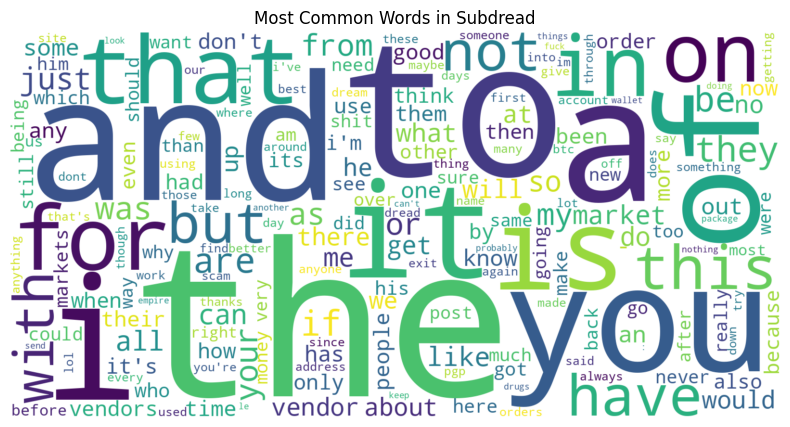

In [41]:
word_dist = nltk.FreqDist(all_tokens)

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(word_dist)
plt.title('Most Common Words in Subdread')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.close()

It should not be surprising that these words are the most common. We need to remove stopwords and common words that only reflect "every day"/informal phrasing. These are words such as "the, to, it, this, was, with".

In [42]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
new_stop_words = ['first', 'many', 'day', 'every', 'work', 'long', 'though', 'better', 'thing', 'lot', 'maybe', 'someone', 'made', "that's", 'getting', 'anything', 'said', 'used', 'since', 'dont', 'like', 'get', 'would', 'know', 'use', 'even', '', '-', 'also', 'make', 'got', 'see', 'still', 'could', 'go', 'much', 'want', 'need', 'going', 'us', 'say', 'using', 'take', 'sure', 'well', 'one', 'good', 'people', 'time', 'think', 'never', 'really', 'way', 'new', 'back', 'right', 'something', 'days', 'always', 'anyone', ':', 'try', 'may', 'probably', "can't", 'around', 'give', 'look', 'yeah', 'another', 'nothing', 'about', 'seems', 'put', 'ago', 'find', 'name', 'great', 'keep', 'real', 'ever', 'without', '&', 'im', 'years', 'send', 'sent', 'please', 'bad', 'actually', 'yes']
stop_words.extend(new_stop_words)

filtered_data['tokens'] = filtered_data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

all_tokens = [token for tokens in filtered_data['tokens'] if tokens is not None for token in tokens]

word_dist = nltk.FreqDist(all_tokens)

[nltk_data] Downloading package stopwords to /home/albert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


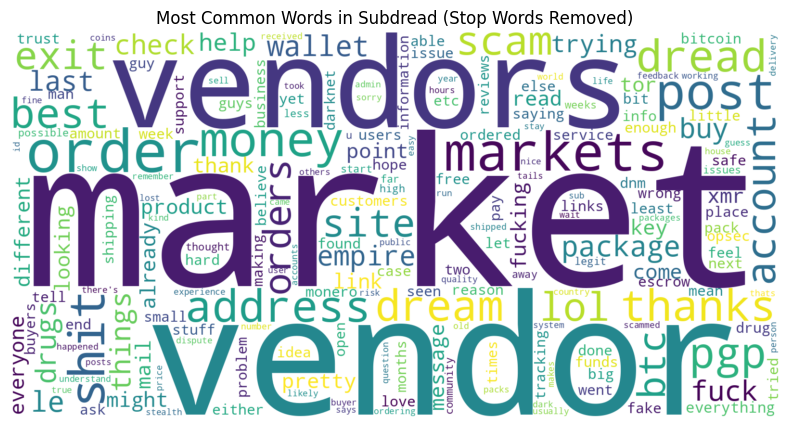

In [43]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(word_dist)
plt.title('Most Common Words in Subdread (Stop Words Removed)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.close()

Removing stopwords gives us a much better idea of the general conversation on Dread.

We can also analyse bigrams and get an idea of what words have a strong relation. As we can see below, some of the most common bigrams are because of the syntax structure of keys shared across the subforum.

In [44]:
from nltk import bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

bigrams = list(bigrams(all_tokens))

bigram_collocation = BigramCollocationFinder.from_words(all_tokens)
top_25_collocations = bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 25)
top_25_collocations

[('exit', 'scam'),
 ('-----begin', 'pgp'),
 ('law', 'enforcement'),
 ('pgp', 'signature-----'),
 ('silk', 'road'),
 ('post', 'office'),
 ('dark', 'web'),
 ('pgp', 'key'),
 ('message-----', 'hash:'),
 ('informed', 'delivery'),
 ('po', 'box'),
 ('-----end', 'pgp'),
 ('united', 'states'),
 ('signed', 'message-----'),
 ('public', 'key'),
 ('stay', 'safe'),
 ('harm', 'reduction'),
 ('dark', 'net'),
 ('tracking', 'number'),
 ('makes', 'sense'),
 ('exit', 'scammed'),
 ('pgp', 'signed'),
 ('love', 'letter'),
 ('marked', 'shipped'),
 ('plausible', 'deniability')]

### Top actors

To compare users (and later communities) text, we must do TF-IDF. IDF is independent of the group and only relies on the word/term. Therfor we can compute IDF for every word and use it for every text analysis.

We define the IDF as the following

$$
\mathrm{IDF}(t) = \log \left( \frac{N}{n_t} \right)
$$
where $N$ is the total number of documents(posts anc comments in our case), and $ n_t $ is the number of documents containing term $ t $ (tokenized word in our case).

The computation of this IDF dictionary takes a long time because we have to go thru every token in every document for every unique token. This is O($n^2$) time complexity for 177.500 documents and more than 50.000 terms. So we will save the IDF in a file that can be used to load the IDF instead.

In [ ]:
# load IDF from file
idf = pd.read_csv('Data/idf.csv')
idf = idf.set_index('word')['idf'].to_dict()

> <span style="color: red">NOTICE:</span> Only run the code block below if you have modified the dataset, as it will take a long time to compute. It took ~50 min with a i5 11400F utilising all threads.

In [ ]:
def count_occurrences(word):
    return word, filtered_data['tokens'].apply(lambda tokens: word in tokens).sum()

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


N = len(filtered_data)

batch_size = 500
occurrences = {}
word_list = all_tokens.unique()
batches = list(chunks(word_list, batch_size))

for batch in tqdm(batches, desc="Processing batches with processes"):
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(count_occurrences, word): word for word in batch}
        for future in as_completed(futures):
            word, count = future.result()
            occurrences[word] = count

idf = {word: math.log(N / occurrences[word]) for word in all_tokens.unique()}

# saving idf in file
with open('Data/idf.json', 'w') as f:
    json.dump(idf, f)

> <span style="color: red">NOTICE:</span> We will be using the degree of the users in the U2U network to identify the top users. To see how the network was made, view the code further down in the notebook

In [79]:
# loading the graph from the json file
with open('Data/U2U.json') as f:
    data = json.load(f)
    U2U = json_graph.node_link_graph(data)

Top 9 actors by degree: [('samwhiskey', 2562), ('HugBunter', 2208), ('dontlaugh', 1332), ('Witchman05', 1210), ('Shakybeats', 1077), ('wombat2combat', 740), ('killswitch', 666), ('Paris', 630), ('MJA20WithA3', 599)]
Top 9 actors degrees out of all degrees: 6.2410126926255955%
though they only represent 0.03173483779971791% of the actors in the network


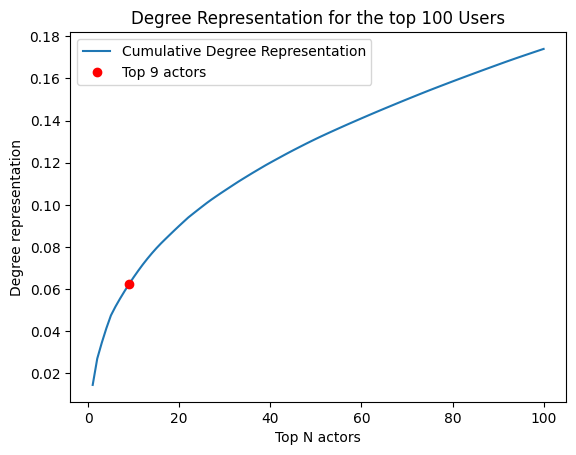

In [80]:
def get_top_actors_by_degree(G, top_n=5, Verbose=False):
    # identify the top n actors by degree
    top_actors = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n]

    sum_degrees = sum([val for (node, val) in G.degree()])
    sum_top_degrees = sum([val for (node, val) in top_actors])
    if Verbose:
        print(f'Top {top_n} actors by degree: {top_actors}')
        print(f'Top {top_n} actors degrees out of all degrees: {sum_top_degrees/sum_degrees*100}%')
        print(f'though they only represent {top_n/G.number_of_nodes()*100}% of the actors in the network')
    return top_actors, sum_top_degrees/sum_degrees


degrees = []

for i in range(1,101):
    _, degree = get_top_actors_by_degree(U2U, top_n=i)
    degrees.append(degree)

plt.plot(range(1,101), degrees, label='Cumulative Degree Representation')
plt.xlabel('Top N actors')
plt.ylabel('Degree representation')
plt.title('Degree Representation for the top 100 Users')

top_9, degree = get_top_actors_by_degree(U2U, top_n=9, Verbose=True)
# Highlight the top 9 actors with a red dot
plt.plot(9, degree, 'ro', label='Top 9 actors')

# Add a legend to the plot
plt.legend()
plt.savefig('Degree_representation.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

We then sort the data to only include the top 9 actors

In [81]:
top_9_data = filtered_data[filtered_data['author'].isin([actor[0] for actor in top_9])]
top_9_data

,type,id,parent_id,title,author,content,tokens
82,comment,c-e558e476c54869fde3,b266607df7c130423f0a,NaN,dontlaugh,probably gas. \r\n ps - not a doctor.,"[gas, ps, doctor]"
88,comment,c-072cd0c4fe4951801a,c-f1ce87ac49f10359a2,NaN,dontlaugh,mate - no discussion of off market sites unles...,"[mate, discussion, market, sites, unless, /d/d..."
103,comment,c-6815349bfef7e5b188,c-23fdcf92f511c62916,NaN,dontlaugh,read the sub rules. next time it's a ban.,"[read, sub, rules, next, ban]"
108,comment,c-b6302fd09f1d09f831,c-c1461548cf4d8e1de1,NaN,samwhiskey,remember reviews go in /d/reviews using a temp...,"[remember, reviews, /d/reviews, template]"
129,comment,c-14b285113a7d3e1a5e,c-c736ac3975f069739e,NaN,dontlaugh,read the sub rules. no self promotion,"[read, sub, rules, self, promotion]"
...,...,...,...,...,...,...,...
197498,comment,c-aafac2e5fe111fb2f9,c-ec312b1131c6bc7675,NaN,Witchman05,we need bots that you can configure to post th...,"[bots, configure, post, automatically, :p]"
197499,comment,c-ec312b1131c6bc7675,c-b02e08a2e06371d9be,NaN,wombat2combat,yeah i am a little late but the previous threa...,"[little, late, previous, thread, old, contain,..."
197502,comment,c-3fc63e1e0f65da378d,c-d48a372caf8e659bb4,NaN,wombat2combat,technically vendor inquires can be posted sepa...,"[technically, vendor, inquires, posted, separa..."
197508,comment,c-aec381f9b9549e579c,c-ea7278ac33ee6846ad,NaN,wombat2combat,it is just an archive of all market announceme...,"[archive, market, announcement, posts, posted,..."


Then the Term Frequency can be computed from this dataframe

In [ ]:
top_9_data['tokens'] = top_9_data['tokens'].apply(lambda x: [word for word in x if word is not pd.notna(word)])
top_9_data = top_9_data[top_9_data['tokens'].map(len) > 0] # removing rows with empty token lists

N = len(top_9_data)

all_tokens = [str(token) for tokens in top_9_data['tokens'] if tokens is not None for token in tokens]
all_tokens_unique = list(set(all_tokens))


top_9_user_tokens = []
top_9_user_tokens_unique = []
top_9_N_tokens = []
top_9_word_dist = []


for i,actor in tqdm(enumerate(top_9), desc="Splitting top 9 actors tokens"):

    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()
    top_9_user_tokens.append(list(actor_tokens))

    top_9_user_tokens_unique.append(set(list(actor_tokens)))

    N_tokens = len(actor_tokens)
    top_9_N_tokens.append(N_tokens)

    word_dist = nltk.FreqDist(actor_tokens)
    top_9_word_dist.append(word_dist)

top_9_tf = []
for i in tqdm(range(9), desc="Calculating TF"):
    tf = {word: top_9_word_dist[i][word]/top_9_N_tokens[i] for word in top_9_word_dist[i]}
    top_9_tf.append(tf)

And finally get TF-IDF of the top 9 actors

In [ ]:
top_9_tfidf = []
for i in tqdm(range(9)):
    tfidf = {word: top_9_tf[i][word] * idf[word] for word in list(top_9_user_tokens_unique[i])}
    top_9_tfidf.append(tfidf)

for i, actor in enumerate(top_9):
    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()


    print(f"user {actor} (with {len(actor_tokens)} tokens):")
    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")

    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

In [ ]:
more_stopwords = ['|', '(', ')', '[', ']', '{', '}', '!', '?', ',', '.', ':', ';', '"', "'", '`', "''", '--', '---', '—', '…', '/', '\\', '@', '#', '$', '%', '^', '&', '*', '+', '=', '<', '>', '«', '»', '“', '”', '–', '•']

for i in range(len(top_9_tfidf)):
    for word in more_stopwords:
        top_9_tfidf[i].pop(word, None)


for i, actor in enumerate(top_9):
    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()


    print(f"user {actor} (with {len(actor_tokens)} tokens):")
    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")

    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

We can then make the wordclouds for the top 9 actors

In [ ]:
# subplot with the 9 top communities
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 Users', fontsize=20)
for i, actor in enumerate(top_9):

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f"{str(actor[0])} ({str(actor[1])} degrees)")
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# These shared words are taken from the wordcloud for the entire dataset
shared_words = ['market', 'vendor', 'markets', 'vendors', 'order', 'lol', 'shit', 'money', 'post', 'things', 'address', 'dread', 'thanks', 'best', 'links', 'link', 'thank', 'sent', 'site', 'exit']
for i in range(len(top_9_tfidf)):
    for word in shared_words:
        top_9_tfidf[i].pop(word, None)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 Users', fontsize=20)
for i, actor in enumerate(top_9):

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f"{str(actor[0])} ({str(actor[1])} degrees)")
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

The following code is an analysis of the marketplaces that are referenced by the top 9 actors. The code for the functions used can be found further down in the notebook as a part of the marketplace network analysis.

In [83]:
batch_size = 1000
results = []

for i in tqdm(range(0, len(top_9_data), batch_size)):
    batch = top_9_data.iloc[i:i+batch_size]
    for _, row in batch.iterrows():
        links = find_onion_links(row['content'])
        aliases = find_site_aliases(row['content'])
        if links or aliases:
            results.append({
                'content': row['content'],
                'links': links,
                'aliases': aliases,
                'author': row['author'],
                'id': row['id']
            })

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/12 [00:00<?, ?it/s]

,content,links,aliases,author,id
0,✅ superlist markets ✅ - /d/archetyp new fe...,None,"[archetyp, archetyp]",samwhiskey,9325a54d99778955139b
1,✅ superlist markets ✅ - /d/archetyp big bo...,None,"[archetyp, archetyp]",samwhiskey,876514123e7d3d508d3b
2,✅ superlist markets ✅ - /d/archetyp psa: e...,None,"[archetyp, archetyp, whonix, whonix, alphabay]",samwhiskey,59b57e2bfcd2bfcf75c4
3,✅ superlist markets ✅ - /d/archetyp -...,None,"[archetyp, archetyp]",samwhiskey,3d88d032b80a6924da78
4,"this isn't something i like doing, but it is i...",None,[silk road],HugBunter,84fb27d3bf3ac2494670
...,...,...,...,...,...
1055,/u/slipperyslim i was asking. cause i know the...,None,"[dream, tmg]",MJA20WithA3,c-a98d69749f7f
1056,/u/freetaykkk free lil tay. c c c \r but yeah ...,None,[dream],MJA20WithA3,c-09026fde81fd
1057,"/u/stayhomiecool thanks, nothing right now, ho...",[http://dreadecomdopooda.onion],None,HugBunter,c-e57491e04835
1058,/u/shoot762x39 1) libertas 2) dream 3) zion \r...,None,[dream],MJA20WithA3,c-5d897cb32195


In [84]:
# Create a new graph
user_link_graph = nx.Graph()

# Add edges between users and links with attributes
for _, row in results_df.iterrows():
    user = row['author']
    if row['links'] is not None:
        for link in row['links']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if link in site['links']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            user_link_graph.add_node(user, group='user')
            # Add link node with attribute
            user_link_graph.add_node(site_name, group='site')
            # Add edge between user and link
            if user_link_graph.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                user_link_graph[user][site_name]['weight'] += 1
            else:
                user_link_graph.add_edge(user, site_name, weight=1)

    if row['aliases'] is not None:
        for alias in row['aliases']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if alias in site['alias']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            user_link_graph.add_node(user, group='user')
            # Add link node with attribute
            user_link_graph.add_node(site_name, group='site')
            # Add edge between user and link
            if user_link_graph.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                user_link_graph[user][site_name]['weight'] += 1
            else:
                user_link_graph.add_edge(user, site_name, weight=1)

# Find the largest connected component
largest_cc = max(nx.connected_components(user_link_graph), key=len)
largest_cc_subgraph = user_link_graph.subgraph(largest_cc).copy()

# Print the number of nodes in the largest connected component
print(f"Largest connected component has {len(largest_cc_subgraph.nodes)} nodes.")

Largest connected component has 62 nodes.


In [ ]:
nw.visualize(largest_cc_subgraph)

We can do other versions of this analysis process. By taking the last 10.000 elements in the filtered_data DataFrame, we can look at the top 9 recent actors by activity count.

In [88]:
top_9_count = filtered_data[:10000]['author'].value_counts().head(9)
print("Top 9 authors by row count:")
print(top_9_count)

top_9 = []
top_9_indexes = top_9_count.index.tolist()
for i in range(len(top_9_indexes)):
    top_9.append((top_9_indexes[i], int(top_9_count[i])))

Top 9 authors by row count:
author
samwhiskey            359
jedi_knight_errant    181
newbieforever2018     120
MrBacon420            109
HugBunter             100
Beelzebub              91
dontlaugh              90
BlackCell              79
HorkyPorky             78
Name: count, dtype: int64


/tmp/ipykernel_170710/261121757.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_9.append((top_9_indexes[i], int(top_9_count[i])))


In [89]:
top_9_data = filtered_data[filtered_data['author'].isin([actor[0] for actor in top_9])]
top_9_data

,type,id,parent_id,title,author,content,tokens
27,comment,c-ee7658fa9f7ff7dccd,0e6c390afaf39e258061,NaN,newbieforever2018,"this only applies to vendors however, customer...","[applies, vendors, however, customers, money, ..."
40,comment,c-a79f1a86c2362ec102,c-9d6345710957e00fb3,NaN,newbieforever2018,"afterall, they're losing money too. \r\n the ...","[afterall, losing, money, motivation, market, ..."
42,comment,c-16b47d194326d6b63f,c-6e7656932dda7fe652,NaN,newbieforever2018,pity that reverse ddos is not a thing. imagine...,"[pity, reverse, ddos, imagine, pissed, archety..."
69,comment,c-14a8ed3495bc40aa11,0e6c390afaf39e258061,NaN,jedi_knight_errant,just now got in...what a shit show. oyy! \r\n ...,"[in...what, shit, show, oyy, thank, hard]"
80,comment,c-48cd86082451b379e3,b266607df7c130423f0a,NaN,newbieforever2018,psyllium husk (cheaper and less additives than...,"[psyllium, husk, cheaper, less, additives, met..."
...,...,...,...,...,...,...,...
197379,comment,c-2da95fde1e50,c-d62ea635b49a,NaN,HugBunter,/u/mja20witha3 i'll work out a solution at som...,"[solution, point, massive, issue, glad, huge, ..."
197380,comment,c-b03e69338b16,c-d62ea635b49a,NaN,HugBunter,"/u/mja20witha3 yes, downvotes are limited beca...","[downvotes, limited, sorting, algorithm, reddi..."
197446,comment,c-d288e86f8a60,c-9e4550a6fcf4,NaN,samwhiskey,lookin back at ya,"[lookin, ya]"
197495,comment,c-622864efea7dc943c9,c-c122397752952fa750,NaN,samwhiskey,make it so number 1,[number]


> <span style="color: blue">Note:</span> We have to re-compute the IDF, because we are looking at a version of the dataset, that is reduced to the last 10.000 components

In [ ]:
N = len(top_9_data)

batch_size = 500
occurrences = {}
word_list = all_tokens.unique()
batches = list(chunks(word_list, batch_size))

for batch in tqdm(batches, desc="Processing batches with processes"):
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(count_occurrences, word): word for word in batch}
        for future in as_completed(futures):
            word, count = future.result()
            occurrences[word] = count

_idf = {word: math.log(N / occurrences[word]) for word in all_tokens.unique()} # notice the underscore, this is to avoid overwriting the original idf

In [ ]:
top_9_data['tokens'] = top_9_data['tokens'].apply(lambda x: [word for word in x if word is not pd.notna(word)])
top_9_data = top_9_data[top_9_data['tokens'].map(len) > 0] # removing rows with empty token lists

N = len(top_9_data)

all_tokens = [str(token) for tokens in top_9_data['tokens'] if tokens is not None for token in tokens]
all_tokens_unique = list(set(all_tokens))


top_9_user_tokens = []
top_9_user_tokens_unique = []
top_9_N_tokens = []
top_9_word_dist = []


for i,actor in tqdm(enumerate(top_9), desc="Splitting top 10 actors tokens"):

    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()
    top_9_user_tokens.append(list(actor_tokens))

    top_9_user_tokens_unique.append(set(list(actor_tokens)))

    N_tokens = len(actor_tokens)
    top_9_N_tokens.append(N_tokens)

    word_dist = nltk.FreqDist(actor_tokens)
    top_9_word_dist.append(word_dist)

top_9_tf = []
for i in tqdm(range(9), desc="Calculating TF"):
    tf = {word: top_9_word_dist[i][word]/top_9_N_tokens[i] for word in top_9_word_dist[i]}
    top_9_tf.append(tf)

In [ ]:
top_9_tfidf = []
for i in tqdm(range(9)):
    tfidf = {word: top_9_tf[i][word] * _idf[word] for word in list(top_9_user_tokens_unique[i])}
    top_9_tfidf.append(tfidf)

for i, actor in enumerate(top_9):
    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()


    print(f"user {actor} (with {len(actor_tokens)} tokens):")
    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")

    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

In [ ]:
more_stopwords = ['|', '(', ')', '[', ']', '{', '}', '!', '?', ',', '.', ':', ';', '"', "'", '`', "''", '--', '---', '—', '…', '/', '///', '\\', '@', '#', '$', '%', '^', '&', '*', '+', '=', '<', '>', '«', '»', '“', '”', '–', '•']
# Remove specific words from the TF-IDF dictionary
for i in range(len(top_9_tfidf)):
    for word in more_stopwords:
        top_9_tfidf[i].pop(word, None)


for i, actor in enumerate(top_9):
    actor_tokens = top_9_data[top_9_data['author'].isin(actor)]['tokens'].explode()


    print(f"user {actor} (with {len(actor_tokens)} users):")
    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")

    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the recent top 9 Users', fontsize=20)
for i, actor in enumerate(top_9):

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f"{str(actor[0])} ({str(actor[1])} degrees)")
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
shared_words = ['market', 'vendor', 'markets', 'vendors', 'order', 'lol', 'shit', 'money', 'post', 'things', 'address', 'dread', 'thanks', 'best', 'links', 'link', 'thank', 'sent', 'site', 'exit']
for i in range(len(top_9_tfidf)):
    for word in shared_words:
        top_9_tfidf[i].pop(word, None)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the recent top 9 Users', fontsize=20)
for i, actor in enumerate(top_9):

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f"{str(actor[0])} ({str(actor[1])} degrees)")
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

And we can once again do the marketplace network for the top 9 actors

In [90]:
# Process data in smaller batches
batch_size = 1000
results = []

for i in tqdm(range(0, len(top_9_data), batch_size)):
    batch = top_9_data.iloc[i:i+batch_size]
    for _, row in batch.iterrows():
        links = find_onion_links(row['content'])
        aliases = find_site_aliases(row['content'])
        if links or aliases:
            results.append({
                'content': row['content'],
                'links': links,
                'aliases': aliases,
                'author': row['author'],
                'id': row['id']
            })

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/8 [00:00<?, ?it/s]

,content,links,aliases,author,id
0,pity that reverse ddos is not a thing. imagine...,None,"[archetyp, archetyp]",newbieforever2018,c-16b47d194326d6b63f
1,✅ superlist markets ✅ - /d/archetyp new fe...,None,"[archetyp, archetyp]",samwhiskey,9325a54d99778955139b
2,✅ superlist markets ✅ - /d/archetyp big bo...,None,"[archetyp, archetyp]",samwhiskey,876514123e7d3d508d3b
3,i did dd with a vendor i knew from dream marke...,None,[dream],Beelzebub,c-52504c144b88cd6ce8
4,"archetype, abacus or druggub are all verified....",None,"[abacus, abacus]",jedi_knight_errant,c-b665a8cf1ad2b35278
...,...,...,...,...,...
528,hey! you can see your subdread subscriptions f...,[http://dreadecomdopooda.onion],None,HugBunter,c-c1ffcf71ddcd
529,/u/tactics420 http://dreadecomdopooda.onion/po...,[http://dreadecomdopooda.onion],None,HugBunter,c-77c30cb180df
530,/u/cartelnorteafrica different guy... you're r...,None,[dream],HugBunter,c-2ea40aef874b
531,"i have a somewhat direct line with him, i've s...",None,[dream],HugBunter,c-8947cac11e91


In [91]:
# Create a new graph
user_link_graph = nx.Graph()

# Add edges between users and links with attributes
for _, row in results_df.iterrows():
    user = row['author']
    if row['links'] is not None:
        for link in row['links']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if link in site['links']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            user_link_graph.add_node(user, group='user')
            # Add link node with attribute
            user_link_graph.add_node(site_name, group='site')
            # Add edge between user and link
            if user_link_graph.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                user_link_graph[user][site_name]['weight'] += 1
            else:
                user_link_graph.add_edge(user, site_name, weight=1)

    if row['aliases'] is not None:
        for alias in row['aliases']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if alias in site['alias']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            user_link_graph.add_node(user, group='user')
            # Add link node with attribute
            user_link_graph.add_node(site_name, group='site')
            # Add edge between user and link
            if user_link_graph.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                user_link_graph[user][site_name]['weight'] += 1
            else:
                user_link_graph.add_edge(user, site_name, weight=1)


# Find the largest connected component
largest_cc = max(nx.connected_components(user_link_graph), key=len)
largest_cc_subgraph = user_link_graph.subgraph(largest_cc).copy()

# Print the number of nodes in the largest connected component
print(f"Largest connected component has {len(largest_cc_subgraph.nodes)} nodes.")

Largest connected component has 58 nodes.


In [ ]:
nw.visualize(largest_cc_subgraph)

---

### User network analysis

The reason for the structure (id,parent_id) of the posts and comments dataset, is how easy it makes the construction of a weighted network.

First we construct a network of nodes composed of the unique authors. Then we go thru every row in the dataset and add an edge from the author of the comment (posts dont have parents) to the author of the row corresponding to the parent_id. If the connection already exist, a weight of +1 is added.

In [45]:
# constructing user-to-user network
U2U = nx.Graph()

authors = filtered_data['author'].unique()
U2U.add_nodes_from(authors)

# adding id as attribute to each author
attr = {}

for index, row in filtered_data.iterrows():
    attr[row['author']] = {'id': row['id']}

for name in tqdm(authors):
    nx.set_node_attributes(U2U, {name: attr[name]})

print(U2U.number_of_nodes())

# adding edges to the graph
for index, row in tqdm(filtered_data.iterrows()):
    if row['parent_id'] != None:
        parent_author = filtered_data[filtered_data['id'] == row['parent_id']]['author']
        # print(parent_author)
        
        if parent_author.empty:
            continue
        elif U2U.has_edge(row['author'], parent_author.iloc[0]): #since parent_author is a series, we need to use iloc[0] to get the first element
            U2U[str(row['author'])][parent_author.iloc[0]]['weight'] += 1
        else:
            U2U.add_edge(row['author'], parent_author.iloc[0], weight=1)

print(f'Number of active users: {U2U.number_of_nodes()}')
print(f'Number of connections: {U2U.number_of_edges()}')

  0%|          | 0/29878 [00:00<?, ?it/s]

29878


0it [00:00, ?it/s]

Number of active users: 29878
Number of connections: 88563


In [46]:
con_comp = nx.connected_components(U2U)
largest = max(con_comp, key=len)
largest_cc = U2U.subgraph(largest)
print(f'The size of the largest component is {largest_cc.number_of_nodes()}')

#connectivity of graph
is_connected = nx.is_connected(U2U)
connected_components = nx.number_connected_components(U2U)
isolated_nodes = nx.number_of_isolates(U2U)
print(f'Is the graph connected: {is_connected}')
print(f'Number of connected components: {connected_components}')
print(f'Number of isolated nodes: {isolated_nodes}')

# size of all the components
all_components = list(nx.connected_components(U2U))
all_components_sizes = [len(component) for component in all_components]
print(f'Sizes of all components: {all_components_sizes}')

The size of the largest component is 28360
Is the graph connected: False
Number of connected components: 1313
Number of isolated nodes: 1141
Sizes of all components: [28360, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1

Most of the users are connectet in one big component. Alot of components have either one or very few nodes. This is due to some people only ever writing few or a post with no reply, or only ever interacting once with another user who is also not interacting with the general subforum. It might also be due to aome other users being banned or getting their posts or comments removed (because this removes the parent thus isolating the comment).

Because almost every user - especially users hwo have had significant activity - is in the largest component, we will ignore the other components.

In [47]:
U2U = largest_cc

partition = best_partition(U2U, randomize=False)

In [48]:
dist=[]
for key in partition.keys():
    U2U.nodes[key]['group'] = partition[key]
    dist.append(partition[key])
print(f'Number of communities: {len(set(dist))}')

Number of communities: 74


Since the process of producing hte network takes a long time it is good to save the network in a file so we can get the same network without having to produce it every time.

In [50]:
# save the graph as a json file
network_data = json_graph.node_link_data(U2U)
with open('Data/U2U.json', 'w') as f:
    json.dump(network_data, f)

In [52]:
# loading the graph from the json file
with open('Data/U2U.json') as f:
    data = json.load(f)
    U2U = json_graph.node_link_graph(data)

We can compute som relevant metrics

In [54]:
#density of graph
density = nx.density(U2U)
print(f'Density of the graph: {density}')

# compute the average, median, mode, minimum, and maximum degree of the nodes
degrees = [val for (node, val) in U2U.degree()]

average_degree = sum(degrees)/len(degrees)
print(f'Average degree: {average_degree}')

median_degree = sorted(degrees)[len(degrees)//2]
print(f'Median degree: {median_degree}')

mode_degree = max(set(degrees), key=degrees.count)
print(f'Mode degree: {mode_degree}')

maximum_degree = max(degrees)
print(f'Maximum degree: {maximum_degree}')

minimum_degree = min(degrees)
print(f'Minimum degree: {minimum_degree}')

# and for the node strength (weighted degree)
strengths = [val for (node, val) in U2U.degree(weight='weight')]

average_strength = sum(strengths)/len(strengths)
print(f'Average strength: {average_strength}')

median_strength = sorted(strengths)[len(strengths)//2]
print(f'Median strength: {median_strength}')

mode_strength = max(set(strengths), key=strengths.count)
print(f'Mode strength: {mode_strength}')

maximum_strength = max(strengths)
print(f'Maximum strength: {maximum_strength}')

minimum_strength = min(strengths)
print(f'Minimum strength: {minimum_strength}')

Density of the graph: 0.00021962764238147296
Average degree: 6.228420310296192
Median degree: 2
Mode degree: 1
Maximum degree: 2562
Minimum degree: 1
Average strength: 10.367983074753173
Median strength: 3
Mode strength: 1
Maximum strength: 5749
Minimum strength: 1


We can use Dijkstra's algorithm to quickly traverse the graph and compute the average shortest path length

In [55]:
# Function to compute the average shortest path length for a specific graph
def average_shortest_path_length(graph):
    total_distance = 0
    num_pairs = 0

    # For each node, compute the shortest paths to all other nodes using Dijkstra's algorithm
    for node in tqdm(range(graph.numberOfNodes())):
        # Dijkstra's algorithm to compute shortest paths from a single node
        distances = nk.distance.Dijkstra(graph, node).run()
        distances = distances.getDistances()

        # Sum the distances (excluding infinity distances)
        for target in range(graph.numberOfNodes()):
            if target != node and distances[target] != float('inf'):
                total_distance += distances[target]
                num_pairs += 1

    # Return the average shortest path length
    return total_distance / num_pairs if num_pairs > 0 else float('inf')

# We have to produce a new graph for networkit from the edgelist of the networkx graph
U2U_int = nx.convert_node_labels_to_integers(U2U, label_attribute="id")
nx.write_edgelist(U2U_int, "largest_subgraph.edgelist", data=False)
U2U_nk = nk.graphio.readGraph("largest_subgraph.edgelist", nk.Format.EdgeList, separator=" ", firstNode=0, directed=False)

# Calculate the average shortest path length for the specific graph
avg_shortest_path_length = average_shortest_path_length(U2U_nk)
print(f"Average Shortest Path Length: {avg_shortest_path_length}")

  0%|          | 0/28360 [00:00<?, ?it/s]

Average Shortest Path Length: 3.993769034549023


In [56]:
def modularity(G, partition):
    '''
    G: NetworkX graph
    partition: dictionary where keys are nodes and values are community assignments
    '''
    m = G.number_of_edges()
    degrees = dict(G.degree())
    Q = 0

    for i in tqdm(G.nodes()):
        for j in G.nodes():
            if partition[i] == partition[j]:
                A_ij = 1 if G.has_edge(i, j) else 0
                deg_i = degrees[i]
                deg_j = degrees[j]
                Q += A_ij - (deg_i * deg_j) / (2 * m)
    
    return Q / (2 * m)
print(f'Modularity of the graph: {modularity(U2U, partition)}')

  0%|          | 0/28360 [00:00<?, ?it/s]

Modularity of the graph: 0.5209758017895086


In [58]:
def AssortativityCoefficient(edges, Attributes):
    total_edges = len(edges)
    same_type_stubs = dict()
    same_type_edges = dict()
    for att in Attributes.values():
        same_type_stubs[att] = 0
        same_type_edges[att] = 0

    for u, v in edges:
        same_type_stubs[Attributes[u]] += 1
        same_type_stubs[Attributes[v]] += 1
        if Attributes[u] == Attributes[v]:
            same_type_edges[Attributes[u]] += 1

    a = dict()
    e = dict()
    for att in Attributes.values():
        a[att] = same_type_stubs[att]/(2*total_edges)
        e[att] = same_type_edges[att]/total_edges

    sigma_e = sum([e[att] for att in list(set(list(Attributes.values())))])
    sigma_aa = sum([a[att]**2 for att in list(set(list(Attributes.values())))])

    return (sigma_e - sigma_aa)/(1 - sigma_aa)
    

community = nx.get_node_attributes(U2U,'group')
r = AssortativityCoefficient(U2U.edges(), community)
print(f"Assortativity coefficient of the graph: {r}")

Assortativity coefficient of the graph: 0.6248626335274392


In [66]:
global_cc = nx.average_clustering(U2U)
print(f"Global clustering coefficient of the graph: {global_cc}")

Global clustering coefficient of the graph: 0.11928637941018086


Moving on to the text analysis of the networks communities. We will be looking at the top 9 communities and make wordclouds based on TF-IDF like with top 9 actors.

In [ ]:
all_communities = sorted(set(partition.values()), key=lambda x: list(partition.values()).count(x), reverse=True)
top_9_communities = all_communities[:9]

filtered_data['tokens'] = filtered_data['tokens'].apply(lambda x: [word for word in x if word is not pd.notna(word)])
filtered_data = filtered_data[filtered_data['tokens'].map(len) > 0] # removing rows with empty token lists


top_9_communities_tokens = []
top_9_communities_tokens_unique = []
top_9_N_tokens = []
top_9_word_dist = []


for community in tqdm(top_9_communities):
    community_nodes = [node for node, comm in partition.items() if comm == community]

    community_tokens = filtered_data[filtered_data['author'].isin(community_nodes)]['tokens'].explode()
    top_9_communities_tokens.append(list(community_tokens))

    top_9_communities_tokens_unique.append(list(set(list(community_tokens))))

    N_tokens = len(community_tokens)
    top_9_N_tokens.append(N_tokens)

    word_dist = nltk.FreqDist(community_tokens)
    top_9_word_dist.append(word_dist)


top_9_tf = []
for i in tqdm(range(9)):
    tf = {word: top_9_word_dist[i][word]/top_9_N_tokens[i] for word in top_9_word_dist[i]}
    top_9_tf.append(tf)

In [ ]:
top_9_tfidf = []
for i in tqdm(range(9)):
    tfidf = {word: top_9_tf[i][word] * idf[word] for word in top_9_communities_tokens_unique[i]}
    top_9_tfidf.append(tfidf)



top_5_users = {}

for i, community in enumerate(top_9_communities):
    community_nodes = [node for node, comm in partition.items() if comm == community]
    community_authors = filtered_data[filtered_data['author'].isin(community_nodes)]
    user_counts = community_authors['author'].value_counts()
    top_5_users[community] = user_counts.head(5).index.tolist()

    print(f"Community {community} (with {len(community_nodes)} users):")
    print("-----------------------------------")
    print(f"Top 5 users:")
    print("--------------------------------------------------") 
    for user in user_counts.head(5).index:
        print(f"{user}: degree {user_counts[user]}")

    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")
    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 communities', fontsize=20)
for i, community in enumerate(top_9_communities):

    community_nodes = [node for node, comm in partition.items() if comm == community]

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f'Community {community} ({len(community_nodes)} users)')
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.savefig('top_9_communities_wordclouds_without_shared_words_removed.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
shared_words = ['market', 'vendor', 'markets', 'vendors', 'order', 'lol', 'shit', 'money', 'post', 'things', 'address', 'dread', 'thanks', 'best', 'links', 'link', 'thank', 'sent', 'site', 'exit']
for i in range(len(top_9_tfidf)):
    for word in shared_words:
        top_9_tfidf[i].pop(word, None)


fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 communities', fontsize=20)
for i, community in enumerate(top_9_communities):

    community_nodes = [node for node, comm in partition.items() if comm == community]

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f'Community {community} ({len(community_nodes)} users)')
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.savefig('top_9_communities_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

---

### Marketplace Network Analysis

The Network will concist of 2 types of nodes. Marketplaces and users. The network is constructed by using the <span style="color: blue">links_to_sites.csv</span> dataframe to search thru the contents of the dataset and connect the users to marketplaces if they either mention an alias for the marketplace or have written a known address for that marketplace. The network is weighted.

In [82]:
# search for website links before tokenizing, onion links contain http:// in the beginning and .onion in the end
def find_onion_links(content):
    # skip if content is not a string
    if not isinstance(content, str):
        return None
    
    # links containing both http:// and .onion
    http_onion = re.compile(r'https?://[^\s]+\.onion(?:[/\w\-]*)')

    # links containing only .onion
    onion = re.compile(r'(?<!://)\b[\w\-]+\.onion(?:[/\w\-]*)')

    links = []

    #process in chunks
    chunk_size = 1000

    for i in range(0, len(content), chunk_size):
        chunk = content[i:i+chunk_size]
        links.extend(http_onion.findall(chunk))
        links.extend(onion.findall(chunk))
    
    # remove duplicates and clean up links
    unique_links = []
    seen = set()
    for link in links:
        # add http:// if not beginning with http://
        if link.startswith('http'):
            clean_link = link.split()[0].rstrip('.,;!?')
        else:
            clean_link = 'http://' + link.split()[0].rstrip('.,;!?')
        
        clean_link = re.match(r'http://[a-z2-7]{16,56}\.onion', clean_link).group(0) if re.match(r'http://[a-z2-7]{16,56}\.onion', clean_link) else None
        
        if clean_link not in seen and clean_link is not None:
            seen.add(clean_link)
            unique_links.append(clean_link)
        
    if len(unique_links) > 0:
        return unique_links
    else:
        return None

def find_site_aliases(row):
    found = []
    # Iterate through each site and its aliases
    for aliases in sites_df['alias']:
        for alias in aliases:
            # Check if the alias is present in the content
            try:
                if " "+alias+" " in row:
                    found.append(alias)
            except: 
                continue
    if len(found) > 0:
        return found
    return None
    

# Process data in smaller batches
batch_size = 1000
results = []

for i in tqdm(range(0, len(filtered_data), batch_size)):
    batch = filtered_data.iloc[i:i+batch_size]
    for _, row in batch.iterrows():
        links = find_onion_links(row['content'])
        aliases = find_site_aliases(row['content'])
        if links or aliases:
            results.append({
                'content': row['content'],
                'links': links,
                'aliases': aliases,
                'author': row['author'],
                'id': row['id']
            })

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/178 [00:00<?, ?it/s]

,content,links,aliases,author,id
0,"hey,\r\n we are super sorry for the interrupti...",None,"[archetyp, archetyp]",BigBossChefOfArchetyp,0e6c390afaf39e258061
1,your having better luck than i am. i use a bra...,None,"[archetyp, archetyp]",EckoSkywalker187,c-df4fdd586c28d92ec7
2,"i agree. i haven't been using archetyp long, t...",None,"[archetyp, archetyp]",Gameras_freend,c-fe87bf0d3c2395f644
3,"respect!💯 nothing but dedication, thats why i ...",None,"[archetyp, archetyp]",goldoversilver112,c-d87426db13cfc9d0e5
4,pity that reverse ddos is not a thing. imagine...,None,"[archetyp, archetyp]",newbieforever2018,c-16b47d194326d6b63f
...,...,...,...,...,...
18046,on whm has good prices but no reviews. says he...,None,[whm],sellnicebuyshit,f116902cb2b0e26f7244
18047,i just talked with genesis market staff and i ...,None,"[cryptonia, genesis]",BulkUSA,c-76e38b0b8a39728ee9
18048,glad to see dread is still alive an kicking! l...,None,[wsm],polar,c-4164823c06fdda2a17
18049,i am a buyer on silk road and am trying to see...,None,[silk road],georgejones,c-e2f5a129d1d78298c9


In [62]:
# Create a new graph
U2L = nx.Graph()

# Add edges between users and links with attributes
for _, row in tqdm(results_df.iterrows()):
    user = row['author']
    if row['links'] is not None:
        for link in row['links']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if link in site['links']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            U2L.add_node(user, group='user')
            # Add link node with attribute
            U2L.add_node(site_name, group='site')
            # Add edge between user and link
            if U2L.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                U2L[user][site_name]['weight'] += 1
            else:
                U2L.add_edge(user, site_name, weight=1)

    if row['aliases'] is not None:
        for alias in row['aliases']:
            site_name = next((site['name'] for _, site in sites_df.iterrows() if alias in site['alias']), 'Unknown')
            if site_name == 'Unknown':
                continue
            # Add user node with attribute
            U2L.add_node(user, group='user')
            # Add link node with attribute
            U2L.add_node(site_name, group='site')
            # Add edge between user and link
            if U2L.has_edge(user,site_name): #since parent_author is a series, we need to use iloc[0] to get the first element
                U2L[user][site_name]['weight'] += 1
            else:
                U2L.add_edge(user, site_name, weight=1)

0it [00:00, ?it/s]

In [63]:
# finding the largest connected component and its size
con_comp = nx.connected_components(U2L)
largest = max(con_comp, key=len)
U2L_largest = U2L.subgraph(largest)
print(f'The size of the largest component is {U2L_largest.number_of_nodes()}')

#connectivity of graph
is_connected = nx.is_connected(U2L)
connected_components = nx.number_connected_components(U2L)
isolated_nodes = nx.number_of_isolates(U2L)
print(f'Is the graph connected: {is_connected}')
print(f'Number of connected components: {connected_components}')
print(f'Number of isolated nodes: {isolated_nodes}')

# size of all the components
all_components = list(nx.connected_components(U2L))
all_components_sizes = [len(component) for component in all_components]
print(f'Sizes of all components: {all_components_sizes}')

The size of the largest component is 7584
Is the graph connected: False
Number of connected components: 5
Number of isolated nodes: 0
Sizes of all components: [7584, 3, 2, 2, 2]


In [67]:
U2L = U2L_largest

partition = best_partition(U2L, randomize=False)

We will do two attributes. community and group. This is to visually distinguish the groups with netwulf. The group was made when making the network.

In [71]:
for node in U2L.nodes():
    U2L.nodes[node]['community'] = partition[node]

In [73]:
# saving the graph as a json file
network_data = json_graph.node_link_data(U2L)
with open('Data/U2L.json', 'w') as f:
    json.dump(network_data, f)

In [75]:
# loading the graph from the json file
with open('Data/U2L.json') as f:
    data = json.load(f)
    U2L = json_graph.node_link_graph(data)

In [76]:
dist=[]
for key in partition.keys():
    dist.append(partition[key])
print(f'Number of communities: {len(set(dist))}')

Number of communities: 15


In [77]:
#density of graph
density = nx.density(U2L)
print(f'Density of the graph: {density}')

# compute the average, median, mode, minimum, and maximum degree of the nodes
degrees = [val for (node, val) in U2L.degree()]

average_degree = sum(degrees)/len(degrees)
print(f'Average degree: {average_degree}')

median_degree = sorted(degrees)[len(degrees)//2]
print(f'Median degree: {median_degree}')

mode_degree = max(set(degrees), key=degrees.count)
print(f'Mode degree: {mode_degree}')

maximum_degree = max(degrees)
print(f'Maximum degree: {maximum_degree}')

minimum_degree = min(degrees)
print(f'Minimum degree: {minimum_degree}')

# and for the node strength (weighted degree)
strengths = [val for (node, val) in U2L.degree(weight='weight')]

average_strength = sum(strengths)/len(strengths)
print(f'Average strength: {average_strength}')

median_strength = sorted(strengths)[len(strengths)//2]
print(f'Median strength: {median_strength}')

mode_strength = max(set(strengths), key=strengths.count)
print(f'Mode strength: {mode_strength}')

maximum_strength = max(strengths)
print(f'Maximum strength: {maximum_strength}')

minimum_strength = min(strengths)
print(f'Minimum strength: {minimum_strength}')


U2L_int = nx.convert_node_labels_to_integers(U2L, label_attribute="id")
nx.write_edgelist(U2L_int, "largest_subgraph.edgelist", data=False)
U2L_nk = nk.graphio.readGraph("largest_subgraph.edgelist", nk.Format.EdgeList, separator=" ", firstNode=0, directed=False)
avg_shortest_path_length = average_shortest_path_length(U2L_nk)
print(f"Average Shortest Path Length: {avg_shortest_path_length}")


print(f'Modularity of the graph: {modularity(U2L, partition)}')


community = nx.get_node_attributes(U2L,'community')
r = AssortativityCoefficient(U2L.edges(), community)
print(f"Assortativity coefficient of the graph: {r}")


global_cc = nx.average_clustering(U2L)
print(f"Global clustering coefficient of the graph: {global_cc}")

Density of the graph: 0.0004378756946333988
Average degree: 3.320411392405063
Median degree: 1
Mode degree: 1
Maximum degree: 2246
Minimum degree: 1
Average strength: 5.934335443037975
Median strength: 1
Mode strength: 1
Maximum strength: 4566
Minimum strength: 1


  0%|          | 0/7584 [00:00<?, ?it/s]

Average Shortest Path Length: 3.5368854716663023


  0%|          | 0/7584 [00:00<?, ?it/s]

Modularity of the graph: 0.5464581660674042
Assortativity coefficient of the graph: 0.6176877204646749
Global clustering coefficient of the graph: 0.008749752475917524


Moving on to the text analysis of the networks communities. We will be looking at the top 9 communities and make wordclouds based on TF-IDF like with top 9 actors.

In [ ]:
all_communities = sorted(set(partition.values()), key=lambda x: list(partition.values()).count(x), reverse=True)
top_9_communities = all_communities[:9]

filtered_data['tokens'] = filtered_data['tokens'].apply(lambda x: [word for word in x if word is not pd.notna(word)])
filtered_data = filtered_data[filtered_data['tokens'].map(len) > 0] # removing rows with empty token lists


top_9_communities_tokens = []
top_9_communities_tokens_unique = []
top_9_N_tokens = []
top_9_word_dist = []


for community in tqdm(top_9_communities):
    community_nodes = [node for node, comm in partition.items() if comm == community]

    community_tokens = filtered_data[filtered_data['author'].isin(community_nodes)]['tokens'].explode()
    top_9_communities_tokens.append(list(community_tokens))

    top_9_communities_tokens_unique.append(list(set(list(community_tokens))))

    N_tokens = len(community_tokens)
    top_9_N_tokens.append(N_tokens)

    word_dist = nltk.FreqDist(community_tokens)
    top_9_word_dist.append(word_dist)


top_9_tf = []
for i in tqdm(range(9)):
    tf = {word: top_9_word_dist[i][word]/top_9_N_tokens[i] for word in top_9_word_dist[i]}
    top_9_tf.append(tf)

In [ ]:
top_9_tfidf = []
for i in tqdm(range(9)):
    tfidf = {word: top_9_tf[i][word] * idf[word] for word in top_9_communities_tokens_unique[i]}
    top_9_tfidf.append(tfidf)



top_5_users = {}

for i, community in enumerate(top_9_communities):
    community_nodes = [node for node, comm in partition.items() if comm == community]
    community_authors = filtered_data[filtered_data['author'].isin(community_nodes)]
    user_counts = community_authors['author'].value_counts()
    top_5_users[community] = user_counts.head(5).index.tolist()

    print(f"Community {community} (with {len(community_nodes)} users):")
    print("-----------------------------------")
    print(f"Top 5 users:")
    print("--------------------------------------------------") 
    for user in user_counts.head(5).index:
        print(f"{user}: degree {user_counts[user]}")

    print("---------------------------------------------------")
    print(f"Top 20 TF-IDF words:")
    print("--------------------------------------------------")
    for word, score in sorted(top_9_tfidf[i].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {score:.4f}")
    print("\n")

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 communities', fontsize=20)
for i, community in enumerate(top_9_communities):

    community_nodes = [node for node, comm in partition.items() if comm == community]

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f'Community {community} ({len(community_nodes)} users)')
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
shared_words = ['market', 'vendor', 'markets', 'vendors', 'order', 'lol', 'shit', 'money', 'post', 'things', 'address', 'dread', 'thanks', 'best', 'links', 'link', 'thank', 'sent', 'site', 'exit']
for i in range(len(top_9_tfidf)):
    for word in shared_words:
        top_9_tfidf[i].pop(word, None)


fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Most Common Words for the top 9 communities', fontsize=20)
for i, community in enumerate(top_9_communities):

    community_nodes = [node for node, comm in partition.items() if comm == community]

    axs[i//3, i%3].imshow(WordCloud(width=1600, height=800, background_color='white', collocations=False).generate_from_frequencies(top_9_tfidf[i]), interpolation='bilinear')
    axs[i//3, i%3].set_title(f'Community {community} ({len(community_nodes)} users)')
    axs[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()
plt.close()

---

# Discussion

It has been realy fun and exiting to learn about the subforum. Through our analysis we have found some key actors and marketplaces. Investigating those further has given a great understanding of the history and current state of the forum.

However, it has been hard to pinpoint marketplaces and their importance throughout the 7 years of Dread because of the restrictions on link sharing. If something could need improvement it is definetly here where the analysis is lacking. Some way of improving the identification of marketplaces and their aliases and acosiated links (also dead ones) would have greatly benefitted the quality of the marketplace network analysis.